# Prediccion de demanda

## Pendiente:
- Imputar los datos faltantes con interpolacion polinomica de cada año o con KNN
- **Mejoras en prediccion simple**: Crear pipeline (funcion) Si se quiere una validacion con solo los datos de entrenamiento

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Con reglas duras  de las variaciones por dia

**Plan:**
1. Sacar entre dias del anios consecutivos la variacion
2. Promediar (o con mediana) la variacion media al dia
3. Multiplicar los valores de los ultimos dias por la variacion calculada en el punto 2.

In [3]:
demanda_df = pd.read_csv(".\Datos\demanda.csv")

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\juanc\AppData\Local\Temp\ipykernel_26244\1703249404.py:1: SyntaxWarning: invalid escape sequence '\D'
  demanda_df = pd.read_csv(".\Datos\demanda.csv")


In [4]:
demanda_prod_df = demanda_df[demanda_df['id_producto']==1]
demanda_prod_df['date'] = pd.to_datetime(demanda_prod_df['date'], format='%Y-%m-%d')

# Primero, asegurar que todas las fechas estan
# Los datos de demanda iniciales no tienen enero 2020
fecha_inicial = pd.to_datetime('2020-01-01')
fechas_df = pd.DataFrame({'date': pd.date_range(start=fecha_inicial, end=demanda_prod_df['date'].max())})
complete_demanda_prod_df = fechas_df.merge(demanda_prod_df
                                           ,how='left'
                                           ,left_on='date'
                                           ,right_on='date'
                                           )


complete_demanda_prod_df['anio'] = complete_demanda_prod_df['date'].dt.year
complete_demanda_prod_df['mes'] = complete_demanda_prod_df['date'].dt.month
complete_demanda_prod_df['dia'] = complete_demanda_prod_df['date'].dt.day

C:\Users\juanc\AppData\Local\Temp\ipykernel_26244\1390649101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demanda_prod_df['date'] = pd.to_datetime(demanda_prod_df['date'], format='%Y-%m-%d')


In [5]:
# Preprocesamiento de la serie de tiempo
complete_demanda_prod_df['demanda'].ffill(inplace=True)
complete_demanda_prod_df['demanda'].bfill(inplace=True)

C:\Users\juanc\AppData\Local\Temp\ipykernel_26244\480715261.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  complete_demanda_prod_df['demanda'].ffill(inplace=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_26244\480715261.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

In [ ]:
complete_demanda_prod_df = complete_demanda_prod_df.sort_values(by='date', ascending=True)
complete_demanda_prod_df.reset_index(drop=True, inplace=True)

# Crear una columna indicadora para el 29 de febrero
complete_demanda_prod_df['is_feb_29'] = complete_demanda_prod_df['date'].apply(lambda x: x.month == 2 and x.day == 29)
complete_demanda_prod_df = complete_demanda_prod_df[~complete_demanda_prod_df['is_feb_29']]

# Crear la clave mes-día
complete_demanda_prod_df['mes_dia'] = complete_demanda_prod_df['mes'].astype(str) + '-' + complete_demanda_prod_df['dia'].astype(str)

# Crear la tabla pivote
transformed_df = complete_demanda_prod_df.pivot_table(index='mes_dia', columns='anio', values='demanda')

# Resetear el índice y eliminar nombres de índice no deseados
transformed_df.reset_index(inplace=True, drop=False)
transformed_df.columns.name = None  # Quita el nombre del índice de columnas

In [7]:
# Dividir la columna 'mes_dia' en dos columnas 'mes' y 'dia'
transformed_df[['mes', 'dia']] = transformed_df['mes_dia'].str.split('-', expand=True)

# Convertir las nuevas columnas a tipo entero si es necesario
transformed_df['mes'] = transformed_df['mes'].astype(int)
transformed_df['dia'] = transformed_df['dia'].astype(int)

In [8]:
# Renombrar columnas de años a 'demanda_{anio}'
transformed_df = transformed_df.rename(columns=lambda x: f"demanda_{x}" if isinstance(x, int) else x)

In [9]:
# Calculo de diferencia de datos
cols_demanda = [c for c in transformed_df.columns if 'demanda' in c]
for i,c in enumerate(cols_demanda):
    if i>0:
        transformed_df['pct_var_rel_{a}_{am1}'.format(a=cols_demanda[i][-4:], am1=cols_demanda[i-1][-4:])] = \
            (transformed_df[cols_demanda[i]] - transformed_df[cols_demanda[i-1]]) / transformed_df[cols_demanda[i-1]]

In [10]:
# Esto se hace de ultimo
# Calcular la media del porcentage de varianza relativo
N_pct_cols = float(len([c for c in transformed_df.columns if 'pct_var_rel' in c]))

# Relleno de los valores de % relativo de variacion con el promedio anual
transformed_df['pct_var_rel_2022_2021'].fillna(transformed_df['pct_var_rel_2022_2021'].mean(), inplace=True)

# Para no terminar con NaN se puede crear una funcion que calcule el promedio y luego se aplica con apply() 
transformed_df['avg_pct_var_rel'] =  (transformed_df['pct_var_rel_2021_2020'] + transformed_df['pct_var_rel_2022_2021']) / N_pct_cols



C:\Users\juanc\AppData\Local\Temp\ipykernel_26244\2171710298.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transformed_df['pct_var_rel_2022_2021'].fillna(transformed_df['pct_var_rel_2022_2021'].mean(), inplace=True)


In [11]:
# Cargue de datos para test:
demanda_test_df = pd.read_csv(".\Datos\demanda_test.csv")
demanda_test_df['date'] = pd.to_datetime(demanda_test_df['date'], format='%Y-%m-%d')
demanda_test_df = demanda_test_df[demanda_test_df['id_producto']==1]

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\juanc\AppData\Local\Temp\ipykernel_26244\3844840410.py:2: SyntaxWarning: invalid escape sequence '\D'
  demanda_test_df = pd.read_csv(".\Datos\demanda_test.csv")


In [12]:
# Primero, asegurar que todas las fechas estan
# fecha_inicial = pd.to_datetime('2020-01-01')
fechas_df = pd.DataFrame({'date': pd.date_range(start=demanda_test_df['date'].min(), end=demanda_prod_df['date'].max())})
complete_demanda_test_df = fechas_df.merge(demanda_test_df
                                           ,how='left'
                                           ,left_on='date'
                                           ,right_on='date'
                                           )

In [13]:
demanda_test_df['anio'] = demanda_test_df['date'].dt.year
demanda_test_df['mes'] = demanda_test_df['date'].dt.month
demanda_test_df['dia'] = demanda_test_df['date'].dt.day

In [14]:
# Asegurarse de que las columnas tienen el mismo nombre y tipo de datos
transformed_df['mes'] = transformed_df['mes'].astype(int)
transformed_df['dia'] = transformed_df['dia'].astype(int)
demanda_test_df['mes'] = demanda_test_df['mes'].astype(int)
demanda_test_df['dia'] = demanda_test_df['dia'].astype(int)

In [15]:
# Prediccion simple - aqui el "entrenamiento" es directamente consecutivo de los datos de prueba
# Una funcion mas robusta es necesaria a futuro

# Realizar el left join nuevamente después de las correcciones
final_transf_df = transformed_df.loc[:, ['mes', 'dia', 'demanda_2020', 'demanda_2021', 'demanda_2022', 'avg_pct_var_rel']]
join_df = demanda_test_df.merge(final_transf_df, how='left', left_on=['mes', 'dia'], right_on=['mes', 'dia'])

In [16]:
# Prediccion final
def simple_predict(row):
    if row['anio'] == 2022 and pd.isna(row['demanda_2022']):
        return row['demanda_2021'] + round(row['demanda_2021']*row['avg_pct_var_rel'])
    else:
        return row['demanda_2022'] + round(row['demanda_2022']*row['avg_pct_var_rel'])
    

join_df['prediccion_demanda'] = join_df.apply(simple_predict, axis=1)

In [17]:
prediction_df = join_df.loc[:,['date', 'prediccion_demanda']]
prediction_df['prediccion_demanda'] = prediction_df['prediccion_demanda'].astype(int)

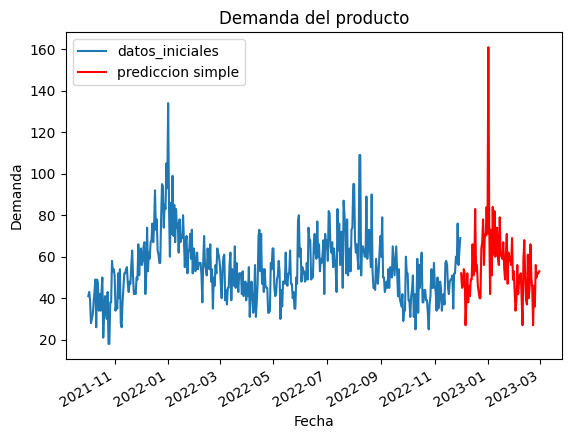

In [18]:
aux_df = complete_demanda_prod_df[complete_demanda_prod_df['date']>'2021-10-01']
plt.plot(aux_df.date, aux_df.demanda)
plt.plot(prediction_df['date'], prediction_df['prediccion_demanda'], color='r')

# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

# Rotar los x-ticks para mayor legibilidad
plt.gcf().autofmt_xdate()

plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.title("Demanda del producto")
plt.legend(['datos_iniciales', 'prediccion simple'])


plt.show()

In [19]:
# Validacion con funcion

# 2. Con un modelo Autoregresivo

## 2.1 Preprocesamiento de datos
**PENDIENTE**:
- El manejo de datos faltantes se hizo en el codigo de la primera seccion, es mejor separarlo para que no dependa del resto de la seccion 1 y sea un modulo aparte.
- Falta un mejor tratamiento de datos atipicos para mejorar la precision del modelo

#### 1. Manejo de datos faltantes
Con interpolacion, ffill o bfill y eliminacion de valores faltantes si hay pocos.

#### 2. Eliminacion de ruido y tendencias
- `seasonal_decompose()`:  para separar tendencia estacionalidad y ruido
    - Es viable restarle el ruido detectado a la serie original?
    - Es necesario aplicar una media movil ademas de la eliminacion del ruido o son mutuamente excluyentes
    - **Respueustas:** Usar la tendencia y la estacionalidad para modelar el ruido, entrenar el modelo con tendencia + estacionalidad, sumar el residuo a la prediccion final
    - Como se si necesito diferenciar la serie?
- Transformaciones (si la varianza no es constante):
    - logaritmica o raiz cuadrada, como valido si la varianza no es constante, alguna prueba de hipotesis?

In [20]:
# Evaluacion de la descomposicion de la serie con STL
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from scipy.stats import levene


**PENDIENTE:** Ajustar parametros de descomposicion del modelo y validar

In [21]:
stl = STL(demanda_prod_df['demanda'], period=365)
decomposicion = stl.fit()

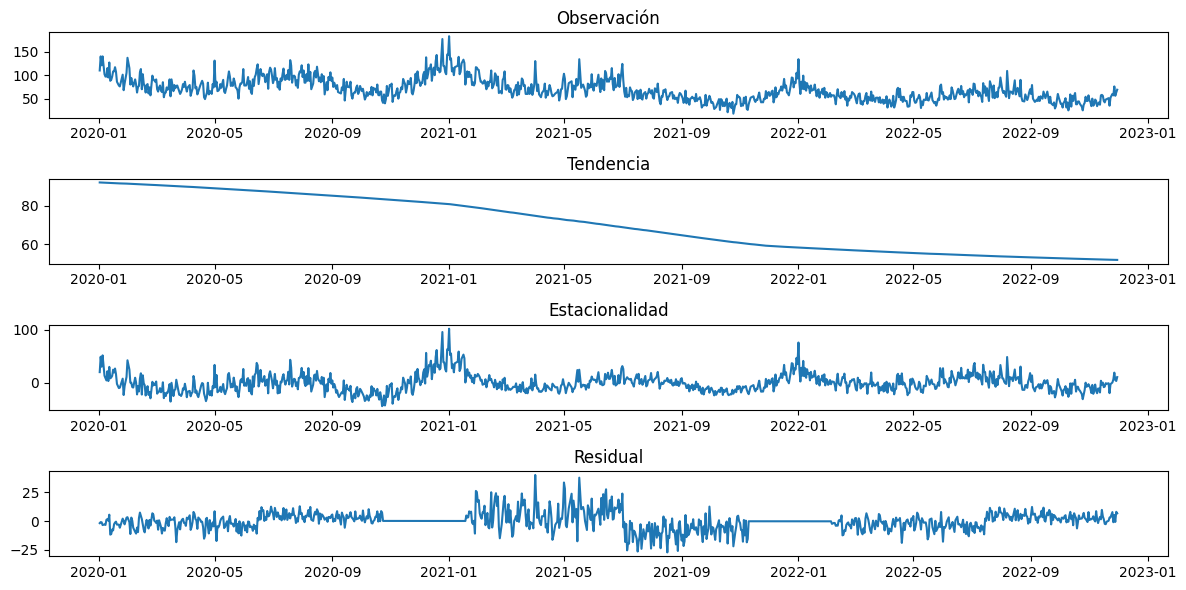

In [22]:

# Graficar los componentes de la descomposición
plt.figure(figsize=(12, 6))

# Observación original
plt.subplot(411)
plt.plot(demanda_prod_df['date'], decomposicion.observed)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Observación')

# Tendencia
plt.subplot(412)
plt.plot(demanda_prod_df['date'], decomposicion.trend)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Tendencia')

# Estacionalidad
plt.subplot(413)
plt.plot(demanda_prod_df['date'], decomposicion.seasonal)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Estacionalidad')

# Residual
plt.subplot(414)
plt.plot(demanda_prod_df['date'], decomposicion.resid)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Residual')

plt.tight_layout()
plt.show()

In [23]:
# Evaluacion de la varianza para saber si necesita alguna transformacion con la prueba de Levine
antes_comp_df = complete_demanda_prod_df[complete_demanda_prod_df['date'] < '2021-07-02']
antes_comp_df.reset_index(inplace=True, drop=True)
despues_comp_df = complete_demanda_prod_df[complete_demanda_prod_df['date'] >= '2021-07-02']
despues_comp_df.reset_index(inplace=True, drop=True)

def levine_test(data_series):
    n = len(data_series) // 2
    # Dividir la serie en dos partes
    parte1 = data_series[:n]  
    parte2 = data_series[n:]    
    # Prueba de Levene para igualdad de varianzas
    stat, p_value = levene(parte1, parte2)
    if p_value < 0.05:
        print("La varianza NO es constante (heterocedasticidad), considera una transformación.")
    else:
        print("La varianza es constante (homocedasticidad), no necesitas transformación.")

# Antes de la aparicion de la competencia
print("Con datos antes de la llegada de la competencia el 2 de julio de 2021")
levine_test(antes_comp_df['demanda'])

print('\n')
# Despues de la aparicion de la competencia
print("Con datos desde la llegada de la competencia el 2 de julio de 2021")
levine_test(despues_comp_df['demanda'])

Con datos antes de la llegada de la competencia el 2 de julio de 2021
La varianza NO es constante (heterocedasticidad), considera una transformación.


Con datos desde la llegada de la competencia el 2 de julio de 2021
La varianza es constante (homocedasticidad), no necesitas transformación.


**Conclusion:** Dado que aparecio la tienda de la competencia el 2 de julio de 2021 lo cual impacto en el negocio, entrenar algun modelo con datos antes de esa fecha pierde relevancia. En este caso, nos quedaremos con que la varianza es constante para los datos desde el 2 de julio de 2021 y no necesitamos transformaciones adicionales de los datos.

#### 3. Verificar estacionariedad:
- Que es la Prueba Dickey-Fuller Aumentada (ADF) (`adfuller()`)

In [24]:
# Prueba ADF
result = adfuller(despues_comp_df['demanda'])

# Extract and print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.2705880606395317
p-value: 0.18162940714924308
Critical Values:
   1%: -3.4435761493506294
   5%: -2.867372960189225
   10%: -2.5698767442886696


C:\Users\juanc\AppData\Local\Temp\ipykernel_26244\360693047.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  despues_comp_df['demanda_diff_1'] = despues_comp_df['demanda'].diff()
C:\Users\juanc\AppData\Local\Temp\ipykernel_26244\360693047.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  despues_comp_df.dropna(inplace=True)


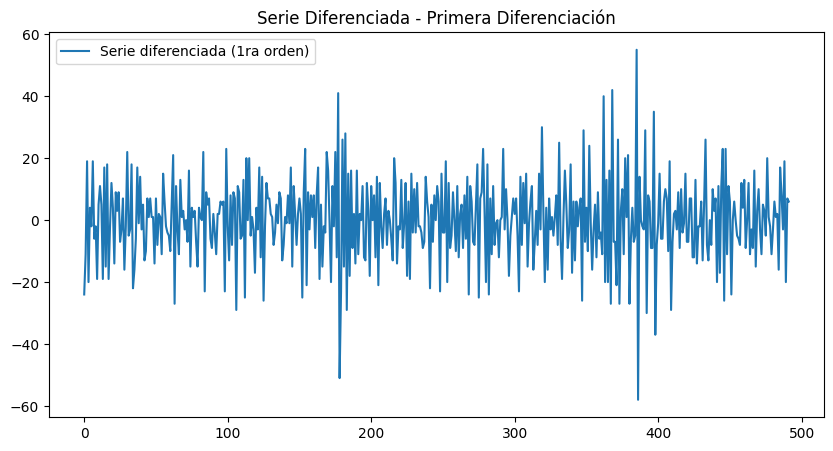

ADF Statistic: -5.282184002665841
p-value: 5.960646377284981e-06
Critical Values:
   1%: -3.444250937448703
   5%: -2.867669873870454
   10%: -2.5700349866579657

✅ La serie se volvió estacionaria con una sola diferenciación.


In [ ]:
# Cargar datos (sustituye esto con tu dataset real)
# df = pd.read_csv('tus_datos.csv', parse_dates=['fecha'], index_col='fecha')

# Aplicar la primera diferenciación
despues_comp_df['demanda_diff_1'] = despues_comp_df['demanda'].diff()

# Eliminar valores NaN generados por la diferenciación
despues_comp_df.dropna(inplace=True)
despues_comp_df.reset_index(inplace=True, drop=True)

# Graficar la serie diferenciada
plt.figure(figsize=(10,5))
plt.plot(despues_comp_df['demanda_diff_1'], label='Serie diferenciada (1ra orden)')
plt.legend()
plt.title('Serie Diferenciada - Primera Diferenciación')
plt.show()

# Prueba ADF en la serie diferenciada
adf_result = adfuller(despues_comp_df['demanda_diff_1'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# Verificar si aún no es estacionaria (p-valor > 0.05), aplicar segunda diferenciación
if adf_result[1] > 0.05:
    print("\nLa serie sigue sin ser estacionaria. Aplicando segunda diferenciación...\n")

    # Segunda diferenciación
    despues_comp_df['demanda_diff_2'] = despues_comp_df['demanda_diff_1'].diff()
    despues_comp_df.dropna(inplace=True)
    despues_comp_df.reset_index(inplace=True, drop=True)
    # Graficar la serie diferenciada (2da orden)
    plt.figure(figsize=(10,5))
    plt.plot(despues_comp_df['demanda_diff_2'], label='Serie diferenciada (2da orden)')
    plt.legend()
    plt.title('Serie Diferenciada - Segunda Diferenciación')
    plt.show()

    # Prueba ADF en la serie diferenciada (2da orden)
    adf_result_2 = adfuller(df['demanda_diff_2'])
    print(f'ADF Statistic (2da orden): {adf_result_2[0]}')
    print(f'p-value: {adf_result_2[1]}')
    print(f'Critical Values:')
    for key, value in adf_result_2[4].items():
        print(f'   {key}: {value}')

# Verifica si ahora la serie es estacionaria
if adf_result[1] < 0.05:
    print("\n✅ La serie se volvió estacionaria con una sola diferenciación.")
elif 'adf_result_2' in locals() and adf_result_2[1] < 0.05:
    print("\n✅ La serie se volvió estacionaria con dos diferenciaciones.")
else:
    print("\n⚠️ La serie aún no es estacionaria. Considera otras transformaciones (log, sqrt).")


## 2.2 Selección de Hiperparámetros (AR, I, MA)
- un analisis de ACF y PACF se hizo en EDA para AR y MA
- Falta analisis de I

El parametro de I se determino anteriormente.

Falta validar los mejores valores de AR y MA.

## 2.3 Creacion de Pipeline de preprocesamiento para series de tiempo
**Nota:** A futuro, revisar cada modulo segun curso de Pau Labarta Bajo

In [26]:
from sklearn.preprocessing import StandardScaler

C:\Users\juanc\AppData\Local\Temp\ipykernel_26244\2963896936.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  antes_comp_df['demanda_diff_1'] = antes_comp_df['demanda'].diff()
C:\Users\juanc\AppData\Local\Temp\ipykernel_26244\2963896936.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  antes_comp_df.dropna(inplace=True)


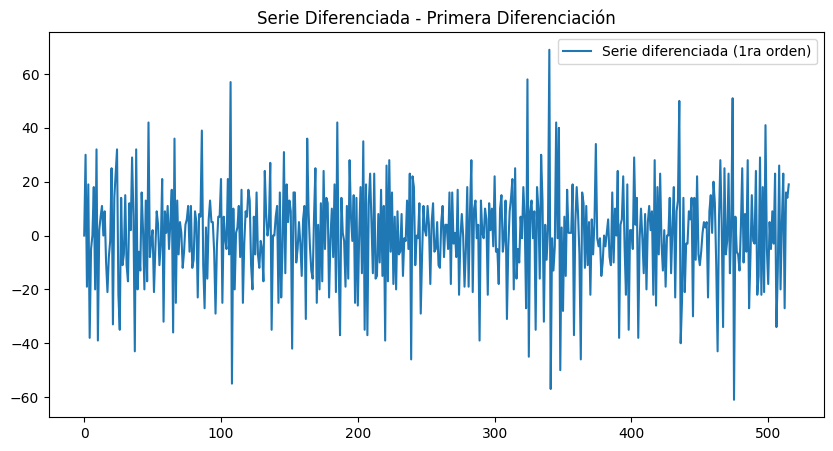

ADF Statistic: -11.827414715898596
p-value: 8.141118402105519e-22
Critical Values:
   1%: -3.4434175660489905
   5%: -2.8673031724657454
   10%: -2.5698395516760275

✅ La serie se volvió estacionaria con una sola diferenciación.


In [27]:
# Diferenciacion de datos antes de aparicion de tienda de la competencia

# Aplicar la primera diferenciación
antes_comp_df['demanda_diff_1'] = antes_comp_df['demanda'].diff()

# Eliminar valores NaN generados por la diferenciación
antes_comp_df.dropna(inplace=True)
antes_comp_df.reset_index(inplace=True, drop=True)

# Graficar la serie diferenciada
plt.figure(figsize=(10,5))
plt.plot(antes_comp_df['demanda_diff_1'], label='Serie diferenciada (1ra orden)')
plt.legend()
plt.title('Serie Diferenciada - Primera Diferenciación')
plt.show()

# Prueba ADF en la serie diferenciada
adf_result = adfuller(antes_comp_df['demanda_diff_1'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# Verificar si aún no es estacionaria (p-valor > 0.05), aplicar segunda diferenciación
if adf_result[1] > 0.05:
    print("\nLa serie sigue sin ser estacionaria. Aplicando segunda diferenciación...\n")

    # Segunda diferenciación
    antes_comp_df['demanda_diff_2'] = antes_comp_df['demanda_diff_1'].diff()
    antes_comp_df.dropna(inplace=True)
    antes_comp_df.reset_index(inplace=True, drop=True)
    # Graficar la serie diferenciada (2da orden)
    plt.figure(figsize=(10,5))
    plt.plot(antes_comp_df['demanda_diff_2'], label='Serie diferenciada (2da orden)')
    plt.legend()
    plt.title('Serie Diferenciada - Segunda Diferenciación')
    plt.show()

    # Prueba ADF en la serie diferenciada (2da orden)
    adf_result_2 = adfuller(df['demanda_diff_2'])
    print(f'ADF Statistic (2da orden): {adf_result_2[0]}')
    print(f'p-value: {adf_result_2[1]}')
    print(f'Critical Values:')
    for key, value in adf_result_2[4].items():
        print(f'   {key}: {value}')

# Verifica si ahora la serie es estacionaria
if adf_result[1] < 0.05:
    print("\n✅ La serie se volvió estacionaria con una sola diferenciación.")
elif 'adf_result_2' in locals() and adf_result_2[1] < 0.05:
    print("\n✅ La serie se volvió estacionaria con dos diferenciaciones.")
else:
    print("\n⚠️ La serie aún no es estacionaria. Considera otras transformaciones (log, sqrt).")


In [28]:
# Aplicando transformacion log a datos para que la varianza no cambie
antes_comp_df['log_demanda'] = np.log(antes_comp_df['demanda'])
despues_comp_df['log_demanda'] = np.log(despues_comp_df['demanda'])


# Funcion para aplicar transformaciones (normalizacion y quizas log o raiz cuadrada)
scaler_antes = StandardScaler()
scaler_despues = StandardScaler()

antes_comp_df['log_demanda_z_scaled'] = scaler_antes.fit_transform(antes_comp_df['log_demanda'].values.reshape(-1, 1))
despues_comp_df['log_demanda_z_scaled'] = scaler_antes.fit_transform(despues_comp_df['log_demanda'].values.reshape(-1, 1))

# Funcion para crear variables exogenas
antes_comp_df['dia_de_semana'] = antes_comp_df['date'].dt.weekday.astype(int)
antes_comp_df['es_fin_de_semana'] = antes_comp_df['date'].dt.weekday.isin([5,6]).astype(int)

despues_comp_df['dia_de_semana'] = despues_comp_df['date'].dt.weekday.astype(int)
despues_comp_df['es_fin_de_semana'] = despues_comp_df['date'].dt.weekday.isin([5,6]).astype(int)

C:\Users\juanc\AppData\Local\Temp\ipykernel_26244\50279397.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  antes_comp_df['log_demanda'] = np.log(antes_comp_df['demanda'])
C:\Users\juanc\AppData\Local\Temp\ipykernel_26244\50279397.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  despues_comp_df['log_demanda'] = np.log(despues_comp_df['demanda'])
C:\Users\juanc\AppData\Local\Temp\ipykernel_26244\50279397.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


2

## 2.3 Entrenamiento del Modelo y Validación Cruzada

- Usar **Time Series Split** para validacion de parametros p (orden AR), d (diferenciacion) y q (Orden MA) usar `gridsearch` o `auto_arima`.
- Evaluacion de modelos con metricas RMSE (Root Mean Squared Error), MAPE (Mean Absolute Percentage Error) y AIC (Akaike Information Criterion)
- Graficar predicciones vs valores reales
- Revisar **residuos** del modelo para asegurar que son ruido blanco Ljung - Box 

Prueba de MVP se hace con Grid Seach desde 0, luego se validara resultados con `auto_arima`.

In [30]:
# Opcion 1, lo hacemos desde 0 con grid_search
import itertools
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
#from statsmodels.tsa.arima_model import ARIMA

In [31]:
# Parámetros a probar
p_values = range(0, 5)  # AR
d_values = [1]  # Ya lo determinaste con ADF
q_values = range(0, 5)  # MA

# Crear combinaciones de p, d, q
param_grid = list(itertools.product(p_values, d_values, q_values))

In [32]:
# Validacion cruzada con 3 splits
tscv = TimeSeriesSplit(n_splits=3)

In [33]:
# Lista que almacena sublistas con la combinacion de (p,d,q) y el promedio de los rmse con esos valores de parametros
results = []

for p, d ,q in param_grid:
    try:
        print(f"Inicio de ejecucion con ({p},{d},{q})")
        errors = []
        for train_idx, test_idx in tscv.split(despues_comp_df['demanda']):
            train, test = despues_comp_df['demanda'][train_idx], despues_comp_df['demanda'][test_idx]

            # Entrenamiento del modelo ARIMA con parametros actuales
            modelo = sm.tsa.arima.ARIMA(train, order=(p, d, q)
                                        , enforce_stationarity=True
                                        , enforce_invertibility=True
                                        )
            modelo_fit = modelo.fit()

            # Predicciones en el conjunto de prueba
            predictions = modelo_fit.forecast(steps=len(test))


            # Calculo de RMSE para un split
            split_rmse = np.sqrt(np.mean((predictions - test)**2))
            errors.append(split_rmse)

        # Promedio de los errores de os splits
        avg_rmse = np.mean(errors)
        results.append(((p, d, q), avg_rmse))
        print("Entrenamiento finalizado")
        print("----------------------------------")

    except Exception as e:
        print(f"Error con la combinacion ({p},{d},{q})")
    #    print(e)
        print("----------------------------------")
    #    continue # en caso de error se ignora esa combinacion
        

Inicio de ejecucion con (0,1,0)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (0,1,1)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (0,1,2)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (0,1,3)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (0,1,4)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (1,1,0)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (1,1,1)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (1,1,2)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (1,1,3)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (1,1,4)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (2,1,0)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (2,1,1)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using ze

Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (2,1,2)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (2,1,3)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (2,1,4)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (3,1,0)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (3,1,1)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (3,1,2)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  w

Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (3,1,3)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (3,1,4)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (4,1,0)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (4,1,1)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (4,1,2)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters

Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (4,1,3)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (4,1,4)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Entrenamiento finalizado
----------------------------------


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
# Seleccionar los mejores parámetros (menor RMSE)
best_params, best_rmse = min(results, key=lambda x: x[1])

print(f"Mejor configuración de ARIMA: {best_params} con RMSE = {best_rmse}")

Mejor configuración de ARIMA: (4, 1, 2) con RMSE = 18.35216839013339


In [35]:
# Funcion para crear modelo ARIMA separando datos de entrenamiento y de prueba
def ts_train_test_split(y, test_size=0.2):
    y_copy = y.copy()
    y_train = y_copy[:int(len(y_copy)*(1-test_size))]
    y_test = y_copy[int(len(y_copy)*(1-test_size)):]
    return y_train, y_test


demanda_train, demanda_test = ts_train_test_split(despues_comp_df['demanda'])


In [36]:
modelo_arima = sm.tsa.arima.ARIMA(train, order=(4, 1, 2)
                                        , enforce_stationarity=True
                                        , enforce_invertibility=True
                                        )
modelo_arima_fit = modelo.fit()

c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
# Predicciones en el conjunto de prueba
predictions = modelo_arima_fit.forecast(steps=len(demanda_test))
predictions = predictions.astype(int)

In [38]:
print(len(predictions))
print(len(demanda_test))

99
99


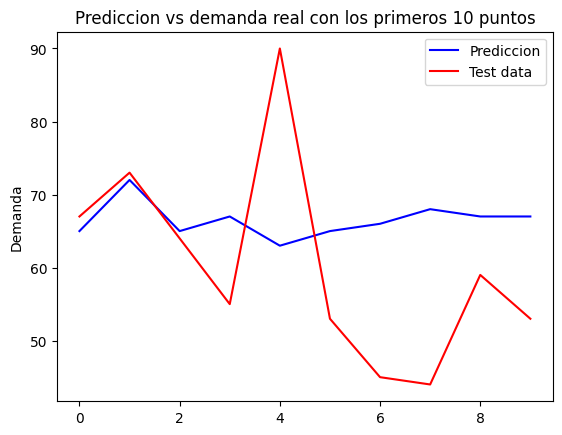

In [39]:
# Comparacion visual de train y test
N_data = 10
plt.plot(range(N_data), predictions[:N_data], color='b')
plt.plot(range(N_data), demanda_test[:N_data], color='r')

# plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.title("Prediccion vs demanda real con los primeros {N} puntos".format(N=N_data))
plt.legend(['Prediccion', 'Test data'])
plt.show()

# 3. Con una Red Neuronal Recurrente o LSTM